['GRBALPHA_20241017T082528_pickled.bin', 'GRBALPHA_20241017T224535_pickled.bin', 'GRBALPHA_20241018T001903_pickled.bin', 'GRBALPHA_20241018T110034_pickled.bin', 'GRBALPHA_20241018T221326_pickled.bin', 'GRBALPHA_20241018T234627_pickled.bin', 'GRBALPHA_20241019T085324_pickled.bin', 'GRBALPHA_20241019T102657_pickled.bin', 'GRBALPHA_20241019T214126_pickled.bin', 'GRBALPHA_20241020T224123_pickled.bin', 'GRBALPHA_20241022T230911_pickled.bin', 'GRBALPHA_20241023T094901_pickled.bin', 'GRBALPHA_20241024T105037_pickled.bin', 'GRBALPHA_20241025T230331_pickled.bin', 'GRBALPHA_20241026T223029_pickled.bin', 'GRBALPHA_20241027T000340_pickled.bin', 'GRBALPHA_20241027T233012_pickled.bin', 'GRBALPHA_20241028T083709_pickled.bin', 'GRBALPHA_20241028T100958_pickled.bin', 'GRBALPHA_20241028T225645_pickled.bin', 'GRBALPHA_20241029T003018_pickled.bin', 'GRBALPHA_20241030T090242_pickled.bin', 'GRBALPHA_20241030T103630_pickled.bin', 'GRBALPHA_20241030T232232_pickled.bin', 'GRBALPHA_20241031T005632_pickled.bin',

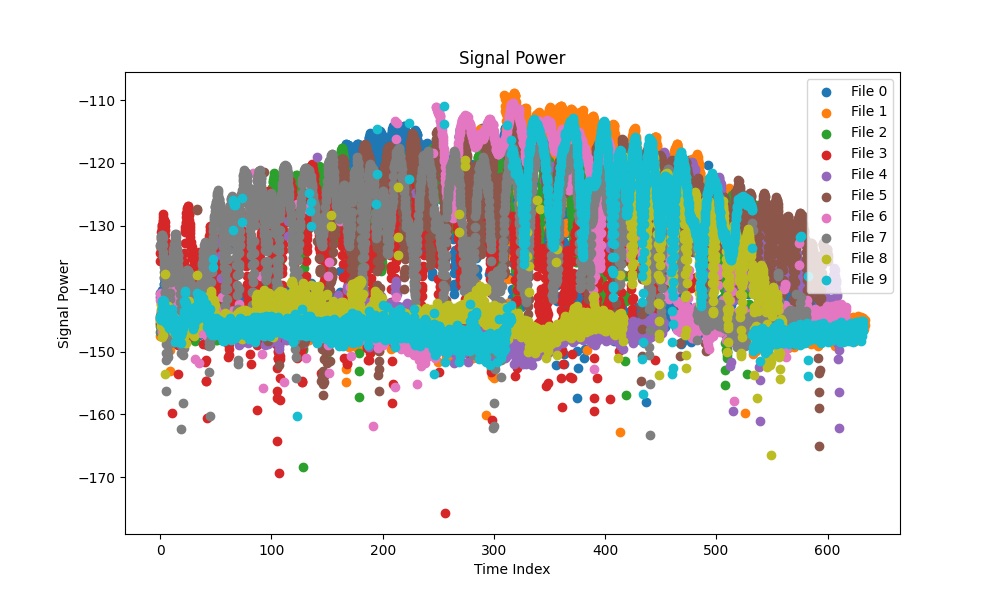

In [2]:
%matplotlib widget
#remember to pip install ipympl
import matplotlib.pyplot as plt
import noisy_moose as nm  # Ensure noisy_moose is installed
import json
import pickle
import numpy as np
import os


# Define the data path
data_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/no_waterfall/active/'
data_path = "C:/Users/asbjo/OneDrive/Dokumenter/GitHub/no_waterfall/active/"

# Get all files in the directory
files = os.listdir(data_path)

# Filter files starting with 'GRBALPHA'
files = [f for f in files if f.startswith('GRBALPHA')]

# Print the filtered files
print(files)

def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def unpickle(file):
    """Unpickles the given file from data_path."""
    try:
        with open(data_path + file, 'rb') as f:
            dump = f.read()
        return pickle.loads(dump)
    except FileNotFoundError:
        print(f"File {file + '_pickled.bin'} not found. Skipping.")
        return None

def extract_features(prop_obj):
    """Extract multiple features from the given object."""
    if prop_obj is None:
        return None  # Skip if object is None

    # Calculate features
    pointing_error = calculate_pointing_error(
        prop_obj.station_obj.set_azimuth, 
        prop_obj.station_obj.set_elevation, 
        prop_obj.station_obj.azimuth, 
        prop_obj.station_obj.elevation
    )
    corrected_power = 10 * np.log10(prop_obj.noise_obj.signal_abs) - prop_obj.station_obj.fspl

    # Features
    features = [
        prop_obj.time_ax,                  # Time (0)
        prop_obj.noise_obj.signal_abs,     # Signal Power (1)
        prop_obj.station_obj.fspl,         # FSPL (2)
        prop_obj.station_obj.dist,         # Distance (3)
        prop_obj.station_obj.set_azimuth,  # Target azimuth (4)
        prop_obj.station_obj.set_elevation,# Target elevation (5)
        pointing_error,                    # Pointing error (6)
        prop_obj.noise_obj.noise,          # Noise power in W/Hz (7)
        corrected_power,                   # FSPL corrected signal power (8)
    ]

    # Find the maximum length
    max_length = max(len(feature) for feature in features)

    # Pad all features to the maximum length
    padded_features = [
        np.pad(feature, (0, max_length - len(feature)), constant_values=np.nan)
        for feature in features
    ]

    # Stack features column-wise
    return np.vstack(padded_features)


# Collect and process data
data_list = []
for f in files[:30]:  # Go through all files
    data: nm.prepping = unpickle(f)
    if data is not None:
        features = extract_features(data)
        if features is not None:
            data_list.append(features)

# Determine maximum length for padding
max_length = max(features.shape[1] for features in data_list)

# Pad the data for each file
padded_data = [
    np.pad(features, ((0, 0), (0, max_length - features.shape[1])), constant_values=np.nan) #all the ones which are not long enough are padded with nan, not ZERO or interpolated.
    for features in data_list
]

# Convert to a 3D numpy array: (file index, feature index, time index)
BAM = np.array(padded_data, dtype=np.float32)
print(f"BAM shape: {BAM.shape} (files, features, time)")

# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

# Threshold

In [3]:
threshold=10**(-138/10) #-138dBm
print(threshold)
for file_idx in range(BAM.shape[0]):
    signal_power = BAM[file_idx, 1, :]  # Signal power is at feature index 1

    # Identify time indices where signal power is below the threshold
    mask = signal_power < threshold

    # Set all features at these time indices to NaN for the current file
    BAM[file_idx, :, mask] = np.nan

1.584893192461111e-14


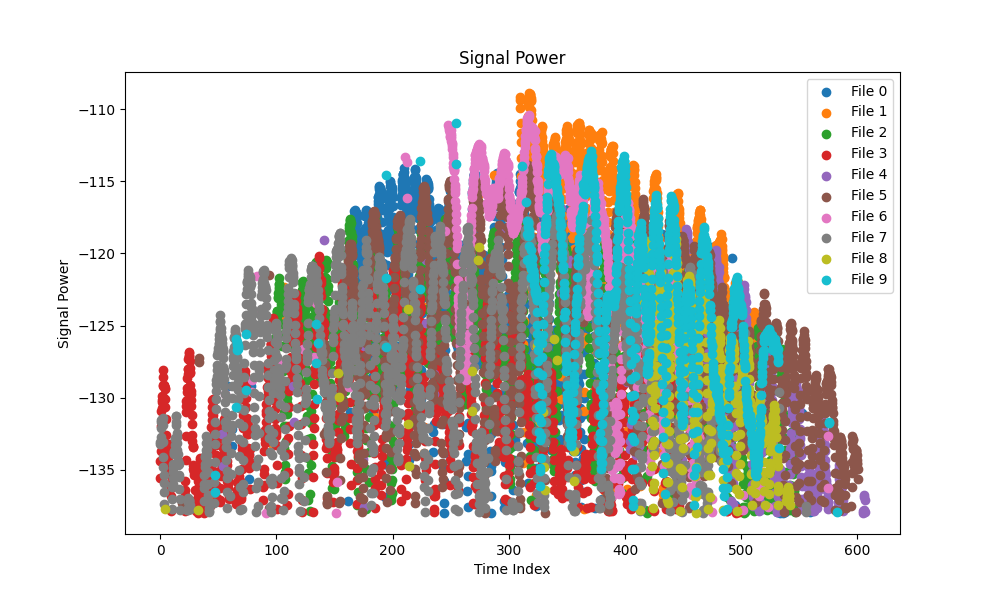

In [4]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

In [12]:
print(BAM.shape) 

# Assume BAM is your matrix
X = BAM[:20, :, :]  
Y = BAM[-10:, :, :]  
print(X.shape, Y.shape)

# Flatten features directly for regression
X_features = X.reshape(-1, X.shape[1])  # Shape: (20 * 3176, 9)
Y_features = Y.reshape(-1, Y.shape[1])  # Shape: (10 * 3176, 9)
print(X_features.shape, Y_features.shape)

# Extract the target variable (Signal Power)
X_signal_power = X_features[:, 1]  # Use only Signal Power (feature 1) as the target
Y_signal_power = Y_features[:, 1]  # Target for prediction


(30, 9, 3176)
(20, 9, 3176) (10, 9, 3176)
(63520, 9) (31760, 9)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd

# Check for missing values
print(f"Missing values in X_features: {np.isnan(X_features).sum()}")
print(f"Missing values in X_signal_power: {np.isnan(X_signal_power).sum()}")

# Handle missing target values before splitting
X_signal_power = np.nan_to_num(X_signal_power, nan=np.nanmean(X_signal_power))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_features, X_signal_power, test_size=0.2, random_state=42
)



# Perform linear interpolation to fill NaN values in y_train
y_train = pd.Series(y_train).interpolate(method='linear').to_numpy()
x_train = pd.Series(X_train).interpolate(method='linear').to_numpy()

# Perform linear interpolation to fill NaN values in y_val
y_val = pd.Series(y_val).interpolate(method='linear').to_numpy()
x_val = pd.Series(X_val).interpolate(method='linear').to_numpy()


# Initialize the model
model = HistGradientBoostingRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on validation data
y_pred_val = model.predict(X_val)

# Evaluate the model
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation MSE with HistGradientBoostingRegressor: {mse_val:.4f}")


Missing values in X_features: 265122
Missing values in X_signal_power: 0


ValueError: Data must be 1-dimensional, got ndarray of shape (50816, 9) instead

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, R²: {r2}")


from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





MSE: 2.4318079100155782e-24, R²: 0.11222779577970965


In [14]:
#impute missing values
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Define pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaNs with mean
    ('model', LinearRegression())
])

# Fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, R²: {r2}")


MSE: 2.7391962338635227e-24, R²: 1.049041748046875e-05


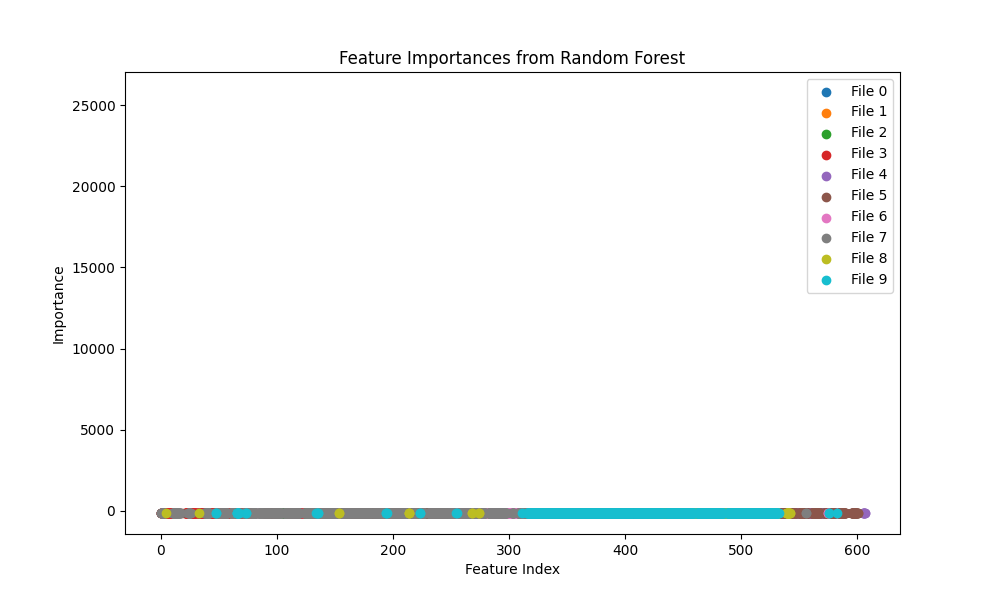

In [16]:
#random forecast regressor:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature Importance
importances = model.feature_importances_
plt.bar(range(X_train.shape[1]), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()


In [17]:
import numpy as np
import pandas as pd

# Assume BAM is your original matrix (satellite_pass, feature, samples)
# Reshape BAM for easier manipulation
bam_reshaped = BAM.transpose(0, 2, 1).reshape(-1, BAM.shape[1])  # Reshape to (total_samples, features)

df = pd.DataFrame(bam_reshaped, columns=['feature_' + str(i) for i in range(BAM.shape[1])])

# Define lag features for signal_abs (e.g., feature_1 is signal_abs)
time_lag = 10  # Lag of 10 samples for input
for lag in range(1, time_lag + 1):
    df[f'signal_abs_lag_{lag}'] = df['feature_1'].shift(lag)

# Define the target: signal_abs shifted 10 steps ahead
df['signal_abs_future'] = df['feature_1'].shift(-10)

# Drop rows with NaN created due to shifting
df = df.dropna()

# Separate inputs (X) and target (y)
X = df.drop(columns=['signal_abs_future'])
y = df['signal_abs_future']


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Train model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, R²: {r2}")


MSE: 2.2120027757395126e-25, R²: 0.9277861512352666


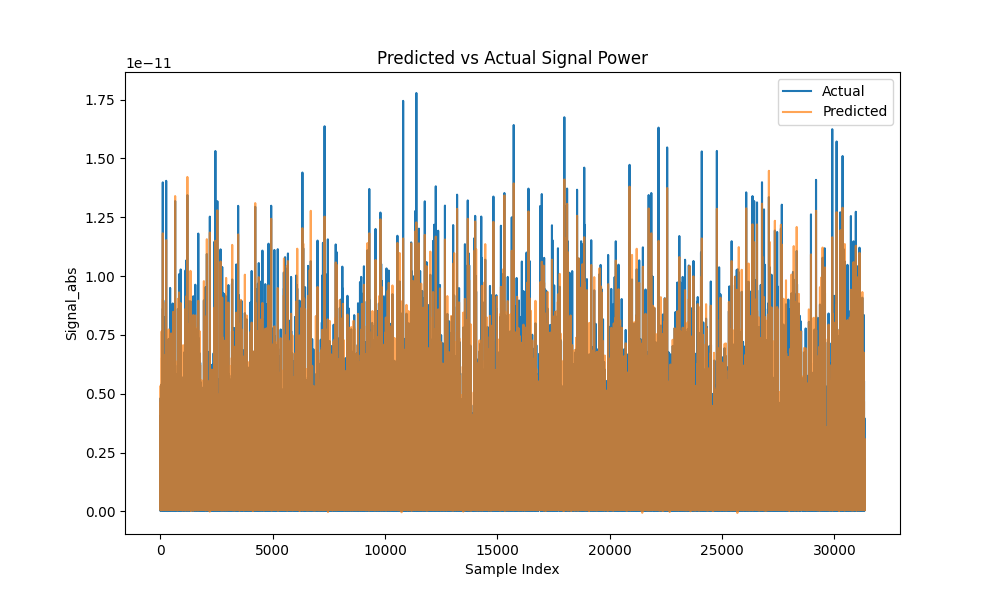

In [23]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Signal Power')
plt.xlabel('Sample Index')
plt.ylabel('Signal_abs')
plt.show()

